In [1]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 25)
plt.style.use('fivethirtyeight')

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
import matplotlib.dates as mdates 
yf.pdr_override() 

%matplotlib inline
#plt.style.use('bmh')

In [2]:
TICKER = "QQQ"

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

df = yf.download(TICKER, 
                 start=start, 
                 end=end)

[*********************100%***********************]  1 of 1 completed


In [3]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

df_macd = get_macd(df['Close'], 26, 12, 9)
#df_macd.tail()

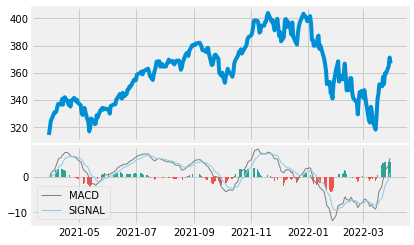

In [4]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower left')

plot_macd(df['Close'], df_macd['macd'], df_macd['signal'], df_macd['hist'])


In [5]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], df_macd)



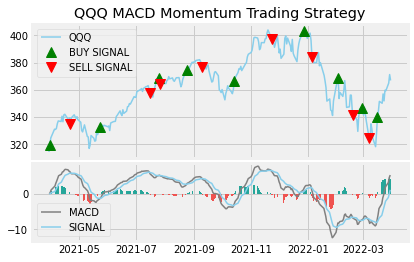

In [6]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['Close'], color = 'skyblue', linewidth = 1.5, label = TICKER)
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title(f'{TICKER} MACD Momentum Trading Strategy')
ax2.plot(df_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(df_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(df_macd)):
    if str(df_macd['hist'][i])[0] == '-':
        ax2.bar(df_macd.index[i], df_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(df_macd.index[i], df_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower left')
plt.show()